# Non-autonomous Neural ODEs in NeuroMANCER  


This tutorial demonstrates the use of [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) (NODE) for system identificaiton of dynamical systems with exogenous inputs. A special case of these models are also referred to as [Neural Controlled Differential Equations](https://arxiv.org/abs/2005.08926).


## System Identification Problem Setup

<img src="../figs/nonauto_ODE.PNG" width="500">  


Starting from a given initial condition  $x_{0}$, the next state of the system  $x_{k+1}$
is obtained by feeding the current state $x_{k}$ and current input $u_{k}$  into the model $S$. In system identification, the loss $\mathcal{L}$ is evaluated by comparing the  trajectory generated by the model with the training trajectory. The process can be repeated for multiple trajectories to improve the generalization of the model.


### References

[1] [Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, David Duvenaud, Neural Ordinary Differential Equations, NeurIPS 2018](https://arxiv.org/abs/1806.07366)  
[2] [Patrick Kidger, James Morrill, James Foster, Terry Lyons, Neural Controlled Differential Equations for Irregular Time Series, NeurIPS 2020](https://arxiv.org/abs/2005.08926)  
[3] http://implicit-layers-tutorial.org/neural_odes/  
[4] https://github.com/Zymrael/awesome-neural-ode  
[5] [Christian Legaard, Thomas Schranz, Gerald Schweiger, Ján Drgoňa, Basak Falay, Cláudio Gomes, Alexandros Iosifidis, Mahdi Abkar, and Peter Larsen. 2023. Constructing Neural Network Based Models for Simulating Dynamical Systems. ACM Comput. Surv. 55, 11, Article 236 (November 2023), 34 pages.](https://dl.acm.org/doi/10.1145/3567591)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [ ]:
!pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"

In [3]:
import torch
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- VanDerPolControl
- IverSimple
- SEIR_population
- LorenzControl

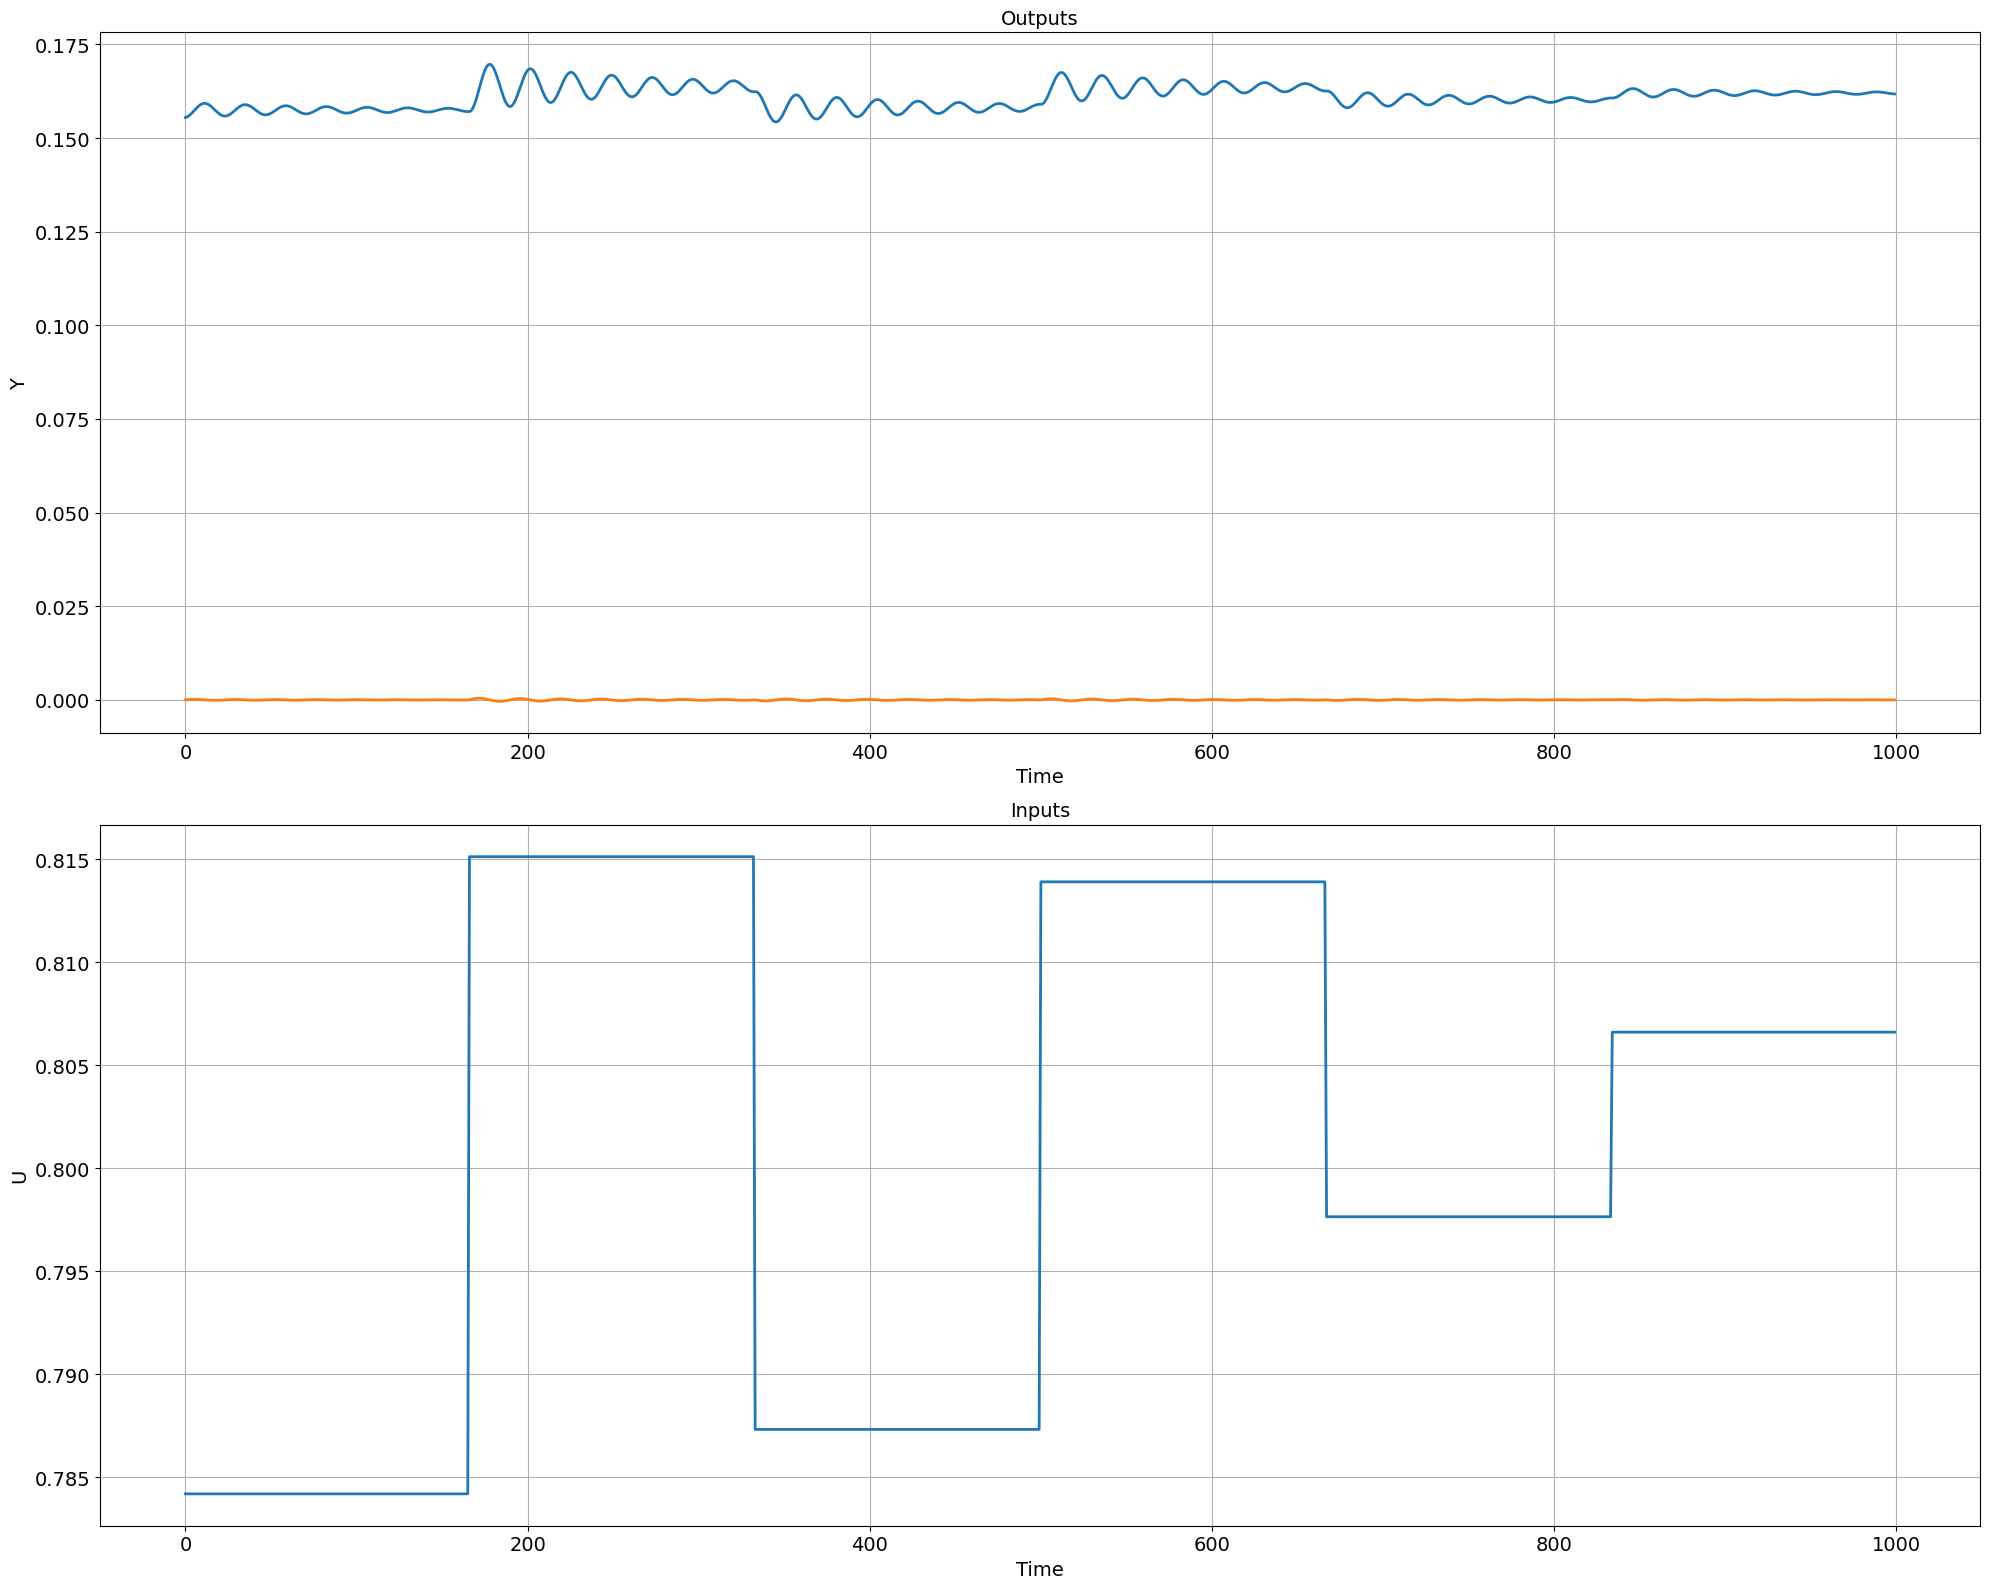

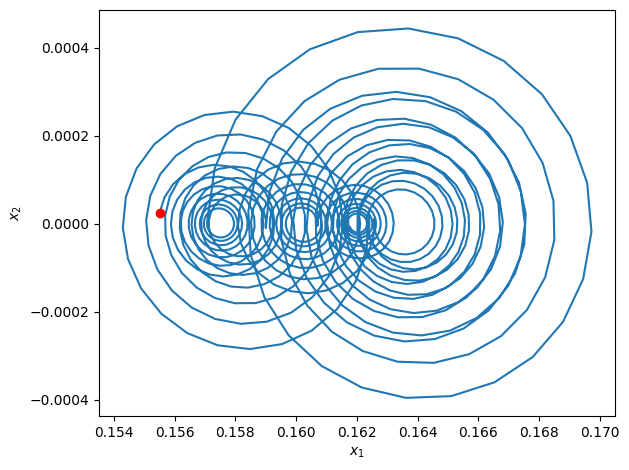

In [4]:
# %%  ground truth system
system_name = 'SwingEquation'
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
nu = modelSystem.nu
raw = modelSystem.simulate(nsim=1000, ts=ts)
plot.pltOL(Y=raw['Y'], U=raw['U'])
plot.pltPhase(X=raw['Y'])

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.


In [25]:
def get_data(sys, nsim, nsteps, ts, bs):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """
    train_sim, dev_sim, test_sim = [sys.simulate(nsim=nsim, ts=ts) for i in range(3)]
    nx = sys.nx
    nu = sys.nu
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    # for systems with out of scale variables it is important to normalize the data before training
    mean_x = modelSystem.stats['X']['mean']
    std_x = modelSystem.stats['X']['std']
    mean_u = modelSystem.stats['U']['mean']
    std_u = modelSystem.stats['U']['std']
    def normalize(x, mean, std):
        return (x - mean) / std

    trainX = normalize(train_sim['X'][:length], mean_x, std_x)
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = normalize(train_sim['U'][:length], mean_u, std_u)
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    devX = normalize(dev_sim['X'][:length], mean_x, std_x)
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = normalize(dev_sim['U'][:length], mean_u, std_u)
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    testX = normalize(test_sim['X'][:length], mean_x, std_x)
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = normalize(test_sim['U'][:length], mean_u, std_u)
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data

In [26]:
nsim = 2000   # number of simulation steps in the dataset
nsteps = 10   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, nsim, nsteps, ts, bs)

## NODE system model in Neuromancer

Here we construct a non-autonomous NODE model  $\dot{x} = f_{\theta}(x, u)$ with trainable parameters $\theta$.

In [27]:
# define neural network of the NODE
fx = blocks.MLP(nx+nu, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.ReLU,
                 hsizes=[80, 80, 80])

Next we need to solve the continuous-time NODE model with suitable ODE solver, e.g., [Runge–Kutta integrator](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods).  
$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$ 

For training we need to obtain accurate reverse-mode gradients of the integrated ODE system. This can be done in two ways, either by unrolling the operations of the ODE solver and using the [backpropagation through time](https://en.wikipedia.org/wiki/Backpropagation_through_time) (BPTT) algorithm, or via [Adjoint state method](https://en.wikipedia.org/wiki/Adjoint_state_method).

Neuromancer provides a set of ODE solvers implemented in [integrators.py](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/dynamics/integrators.py).
For adjoint method we provide the interface to the [open-source implementation](https://github.com/rtqichen/torchdiffeq) via DiffEqIntegrator class. In this example we will use BPTT algorithm through unrolled RK4 solver.

In [28]:
# integrate NODE with adjoint-based solver
fxRK4 = integrators.RK4(fx, h=ts)

Next we construct an open-loop system composed of a smbolic NODE model

In [29]:
# create symbolic system model in Neuromancer
model = Node(fxRK4, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model = System([model], name='system', nsteps=nsteps)

In [30]:
# visualize the system
# dynamics_model.show()

## Define system identification loss function terms

Here we define loss function terms to fit the ODE parameters from given time-series data.

**Tracking loss:**  
$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$ 
**One-step loss:**  
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$ 

In [31]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

# trajectory tracking loss
reference_loss = 5.*(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = 1.*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset $D$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k, u^i_k)) \\
\end{align}
$$  

In [32]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem([dynamics_model], loss)

In [33]:
# plot computational graph
# problem.show()

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [34]:
optimizer = torch.optim.Adam(problem.parameters(),
                             lr=0.003)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=100,
    warmup=100,
    epochs=1000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 13442


In [35]:
# %% train
best_model = trainer.train()
problem.load_state_dict(best_model)

epoch: 0	train_loss: 12.00822	dev_loss: 6.85817	eltime:  0.55623
epoch: 1	train_loss: 9.15057	dev_loss: 5.50923	eltime:  0.62822
epoch: 2	train_loss: 11.41666	dev_loss: 10.18896	eltime:  0.67510
epoch: 3	train_loss: 10.33906	dev_loss: 6.41451	eltime:  0.74989
epoch: 4	train_loss: 9.93736	dev_loss: 7.95866	eltime:  0.82799
epoch: 5	train_loss: 8.18993	dev_loss: 6.59667	eltime:  0.89348
epoch: 6	train_loss: 7.03422	dev_loss: 8.03113	eltime:  0.95956
epoch: 7	train_loss: 8.00260	dev_loss: 6.62821	eltime:  1.02428
epoch: 8	train_loss: 7.60398	dev_loss: 7.33404	eltime:  1.09583
epoch: 9	train_loss: 4.63643	dev_loss: 6.85798	eltime:  1.17106
epoch: 10	train_loss: 4.68001	dev_loss: 5.04861	eltime:  1.24117
epoch: 11	train_loss: 3.91790	dev_loss: 5.15658	eltime:  1.30708
epoch: 12	train_loss: 4.57813	dev_loss: 4.46589	eltime:  1.38779
epoch: 13	train_loss: 4.25862	dev_loss: 4.55964	eltime:  1.46052
epoch: 14	train_loss: 3.38353	dev_loss: 4.41488	eltime:  1.53842
epoch: 15	train_loss: 3.43508	d

epoch: 127	train_loss: 0.00557	dev_loss: 0.01238	eltime:  9.63762
epoch: 128	train_loss: 0.00689	dev_loss: 0.00801	eltime:  9.70739
epoch: 129	train_loss: 0.00405	dev_loss: 0.00491	eltime:  9.77902
epoch: 130	train_loss: 0.00613	dev_loss: 0.01098	eltime:  9.87013
epoch: 131	train_loss: 0.00375	dev_loss: 0.00670	eltime:  9.94852
epoch: 132	train_loss: 0.00708	dev_loss: 0.01081	eltime:  10.02178
epoch: 133	train_loss: 0.00344	dev_loss: 0.01157	eltime:  10.09267
epoch: 134	train_loss: 0.01018	dev_loss: 0.00675	eltime:  10.16331
epoch: 135	train_loss: 0.00456	dev_loss: 0.00809	eltime:  10.23546
epoch: 136	train_loss: 0.00448	dev_loss: 0.01019	eltime:  10.29865
epoch: 137	train_loss: 0.00424	dev_loss: 0.00978	eltime:  10.37323
epoch: 138	train_loss: 0.00364	dev_loss: 0.00896	eltime:  10.43635
epoch: 139	train_loss: 0.00315	dev_loss: 0.00975	eltime:  10.53062
epoch: 140	train_loss: 0.00354	dev_loss: 0.00739	eltime:  10.61982
epoch: 141	train_loss: 0.00365	dev_loss: 0.00301	eltime:  10.69973


epoch: 250	train_loss: 0.00246	dev_loss: 0.00234	eltime:  18.88212
epoch: 251	train_loss: 0.00132	dev_loss: 0.00430	eltime:  18.96429
epoch: 252	train_loss: 0.00252	dev_loss: 0.00541	eltime:  19.03883
epoch: 253	train_loss: 0.00144	dev_loss: 0.00097	eltime:  19.11230
epoch: 254	train_loss: 0.00190	dev_loss: 0.00634	eltime:  19.17456
epoch: 255	train_loss: 0.00220	dev_loss: 0.00289	eltime:  19.24121
epoch: 256	train_loss: 0.00181	dev_loss: 0.00960	eltime:  19.33748
epoch: 257	train_loss: 0.00675	dev_loss: 0.00576	eltime:  19.42218
epoch: 258	train_loss: 0.00126	dev_loss: 0.00528	eltime:  19.52805
epoch: 259	train_loss: 0.00524	dev_loss: 0.00659	eltime:  19.62389
epoch: 260	train_loss: 0.00160	dev_loss: 0.00957	eltime:  19.69028
epoch: 261	train_loss: 0.00747	dev_loss: 0.00654	eltime:  19.76131
epoch: 262	train_loss: 0.00146	dev_loss: 0.00722	eltime:  19.85322
epoch: 263	train_loss: 0.00984	dev_loss: 0.00795	eltime:  19.92430
epoch: 264	train_loss: 0.00243	dev_loss: 0.00637	eltime:  19.9

<All keys matched successfully>

## Parameter estimation results

In [36]:
# update the rollout length based on the test data
dynamics_model.nsteps = test_data['X'].shape[1]

In [37]:
# Test set results
test_outputs = dynamics_model(test_data)

pred_traj = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)
pred_traj, true_traj = pred_traj.transpose(1, 0), true_traj.transpose(1, 0)

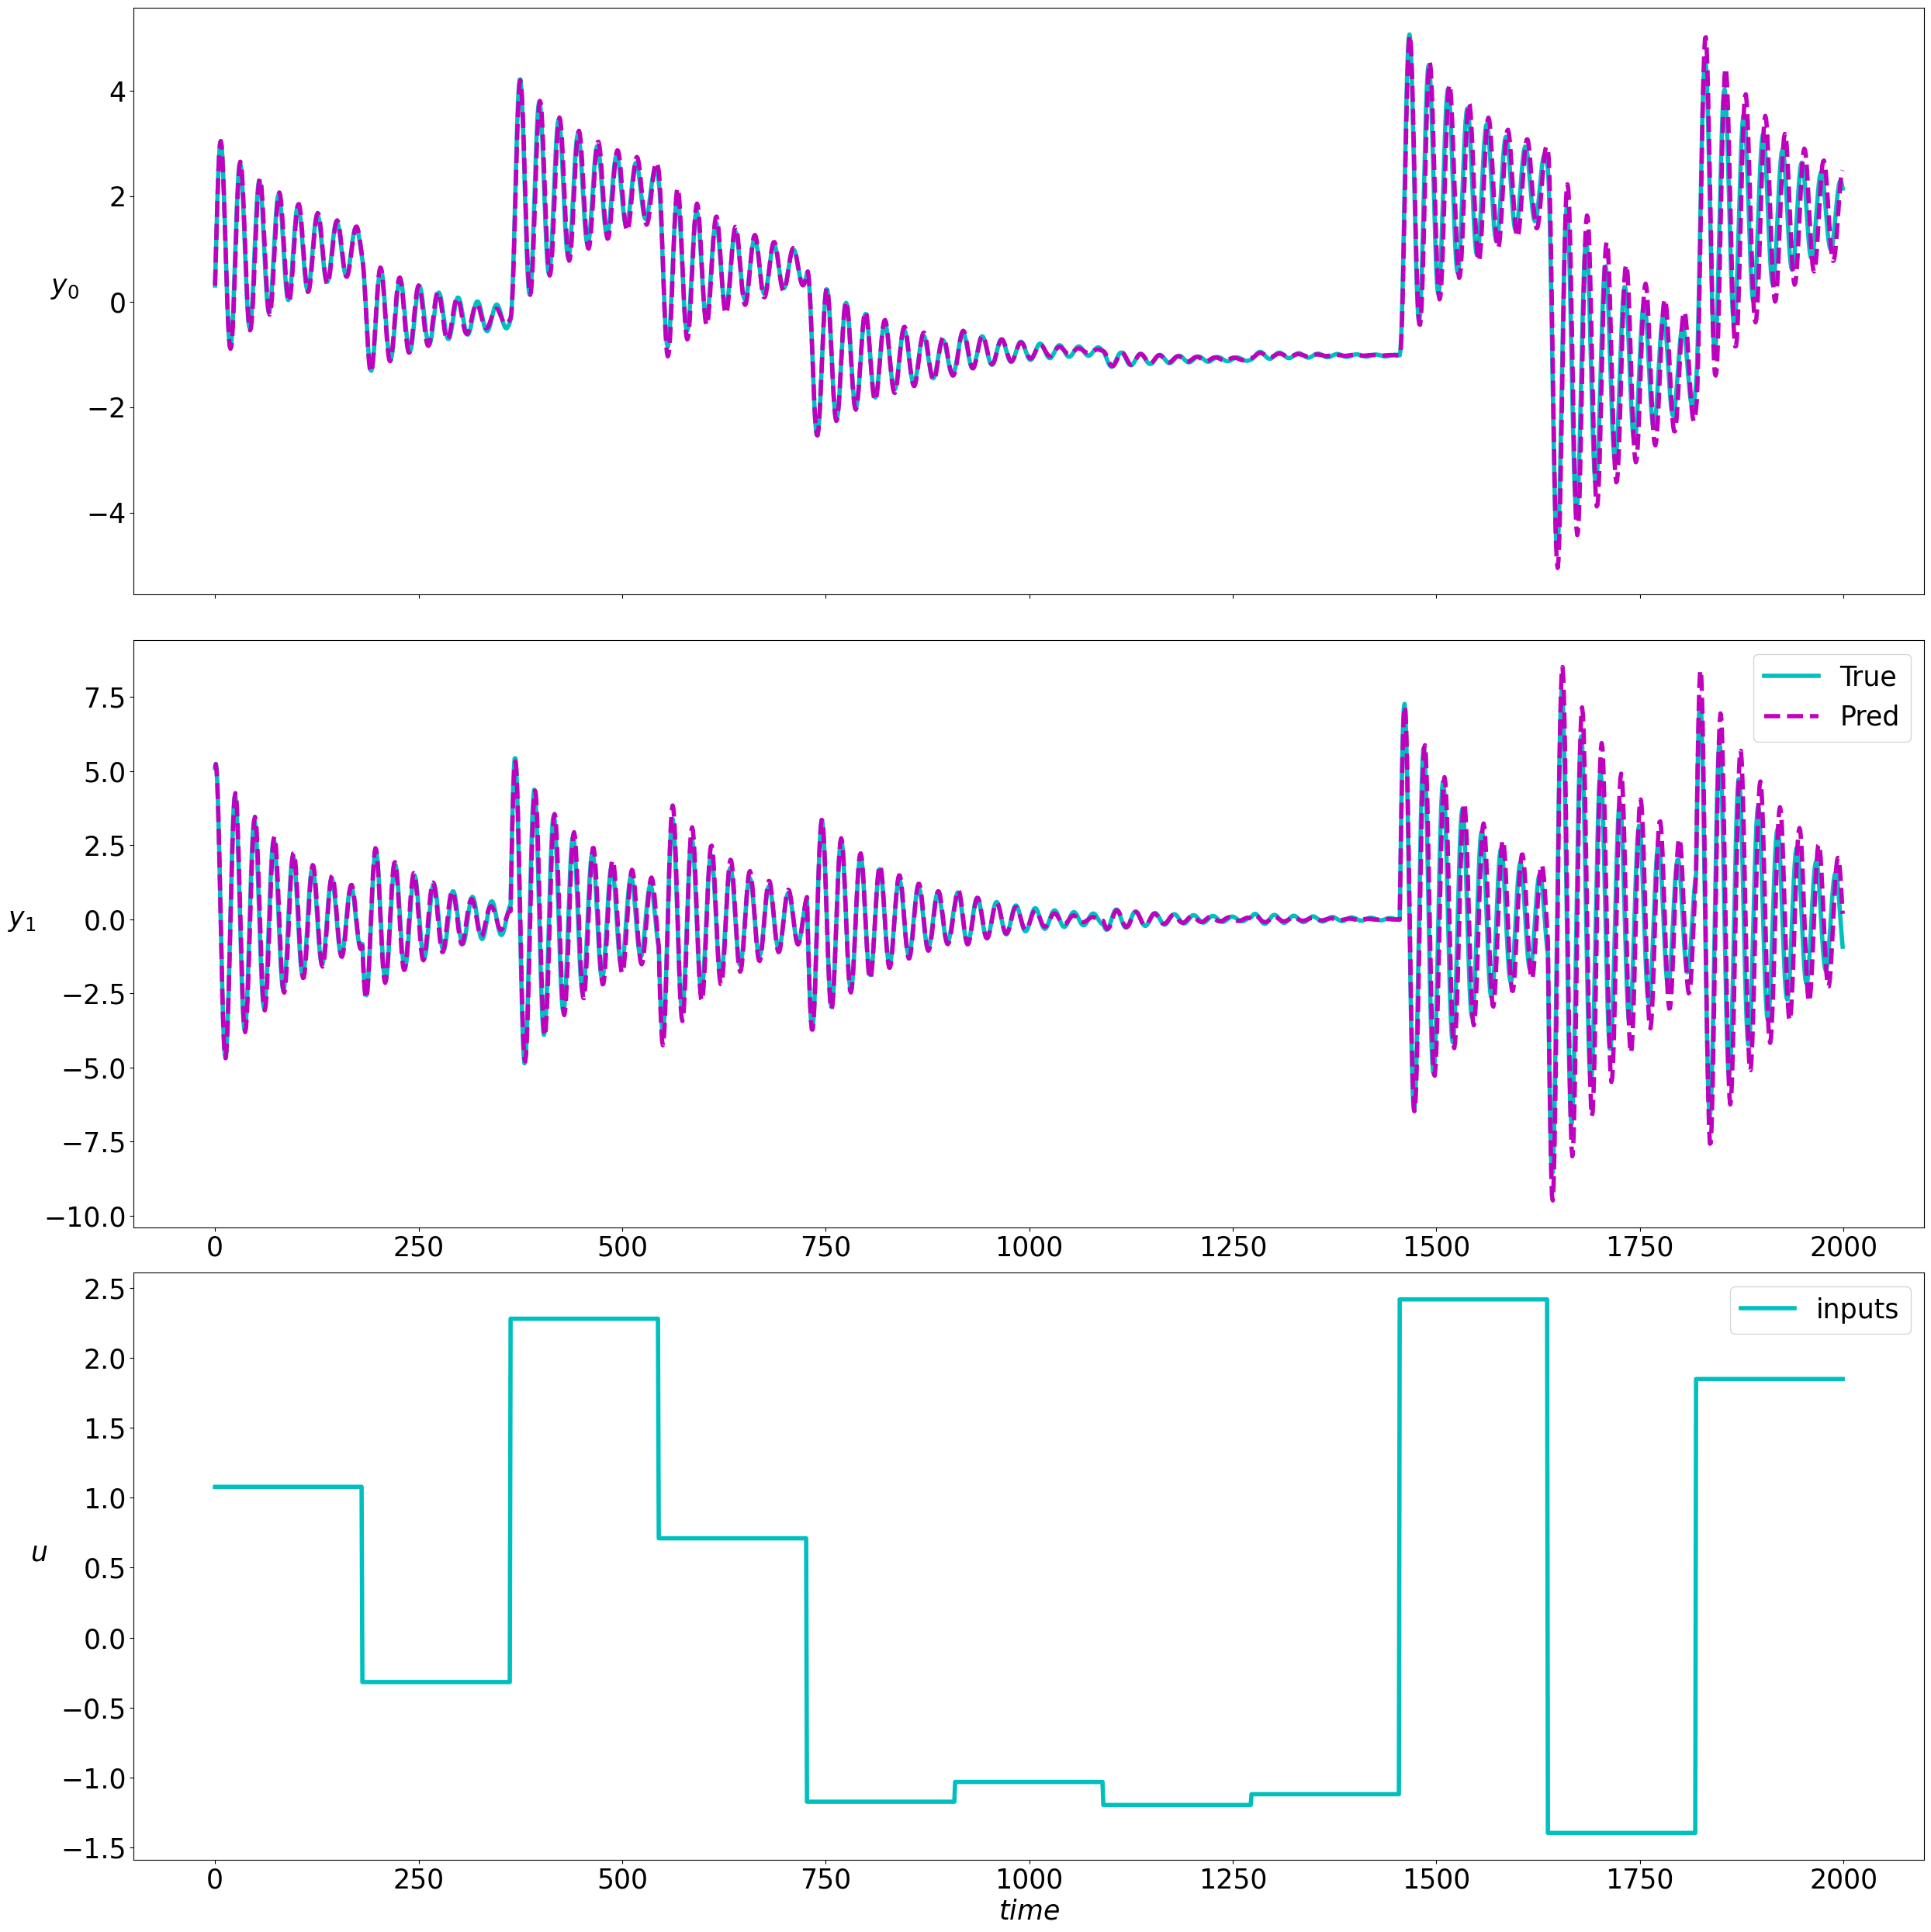

In [43]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx+nu, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))] 
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, 'c', linewidth=4.0, label='True')
    axe.plot(t2, 'm--', linewidth=4.0, label='Pred')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)
ax[-1].plot(input_traj, 'c', linewidth=4.0, label='inputs') 
ax[-1].legend(fontsize=figsize)
ax[-1].set_xlabel('$time$', fontsize=figsize)
ax[-1].set_ylabel('$u$', rotation=0, labelpad=20, fontsize=figsize)
ax[-1].tick_params(labelbottom=True, labelsize=figsize)
plt.tight_layout()